# Sea level fingerprints

Today we are going to consider how sea level changes as ice sheets melt. In doing this we will see a further application of the spherical harmonic methods developed last time, and also  consider the iterative solution of an **integral equation** that arises within sea level theory. The full deglacial sea level problem is rather complicated, but we will simplify things substantially by neglecting viscoelastic deformation within the Earth. In spite of this and some other approximations  outlined below, the resulting theory is actually still quite useful. In particular, it allows us to estimate sea level changes immediately following periods of rapid ice melt, with rapid here being relative to the Earth's viscoelastic relaxation time-scale of around 1000 years. 

Before doing anything else, we import some standard libraries along with PYSHTOOLS used last time 
for working with spherical harmonics. We also import a small module containing functions needed for the sea level problem.


In [1]:
%load_ext autoreload
%autoreload 2

# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

# set some plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]


# store some physical parameters
b    = SL.b    # Earth's mean radius
g    = SL.g    # Earth's mean surface gravity
G    = SL.G    # Gravitational constant
rhoi = SL.rhoi # density of ice
rhow = SL.rhow # density of water

# Loading in present day sea level and ice data

Next we will read in a data file containing present day **sea level** and **ice height** taken from the model
ICE-6G (VM2) of Peltier (2004):

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176



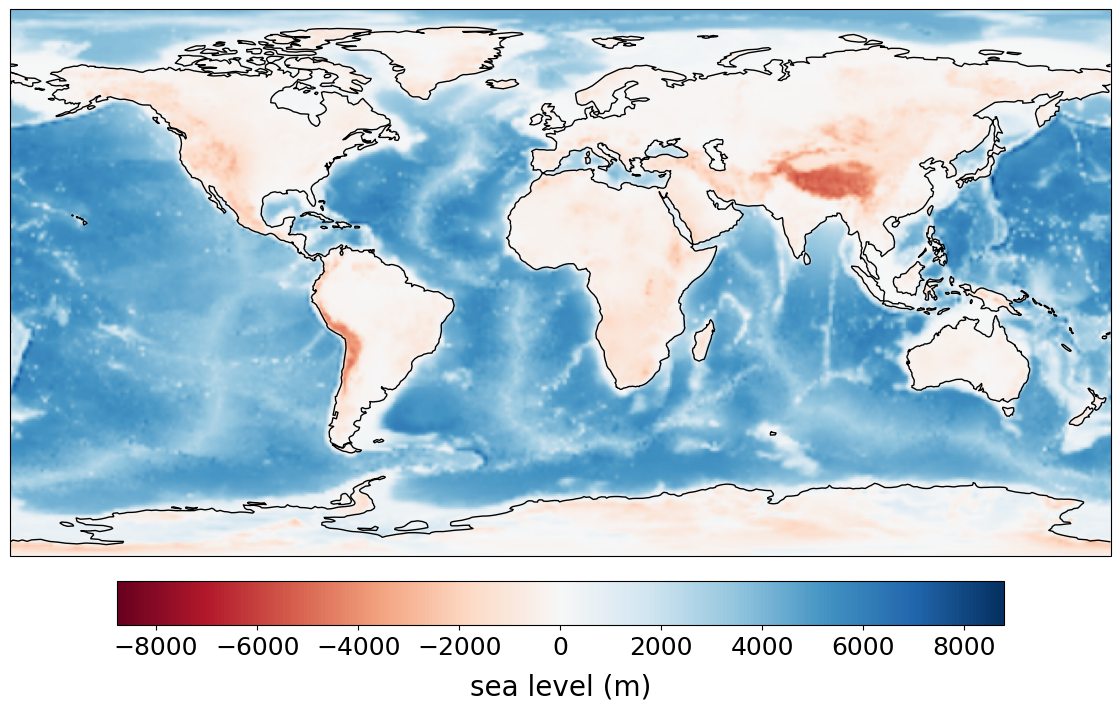

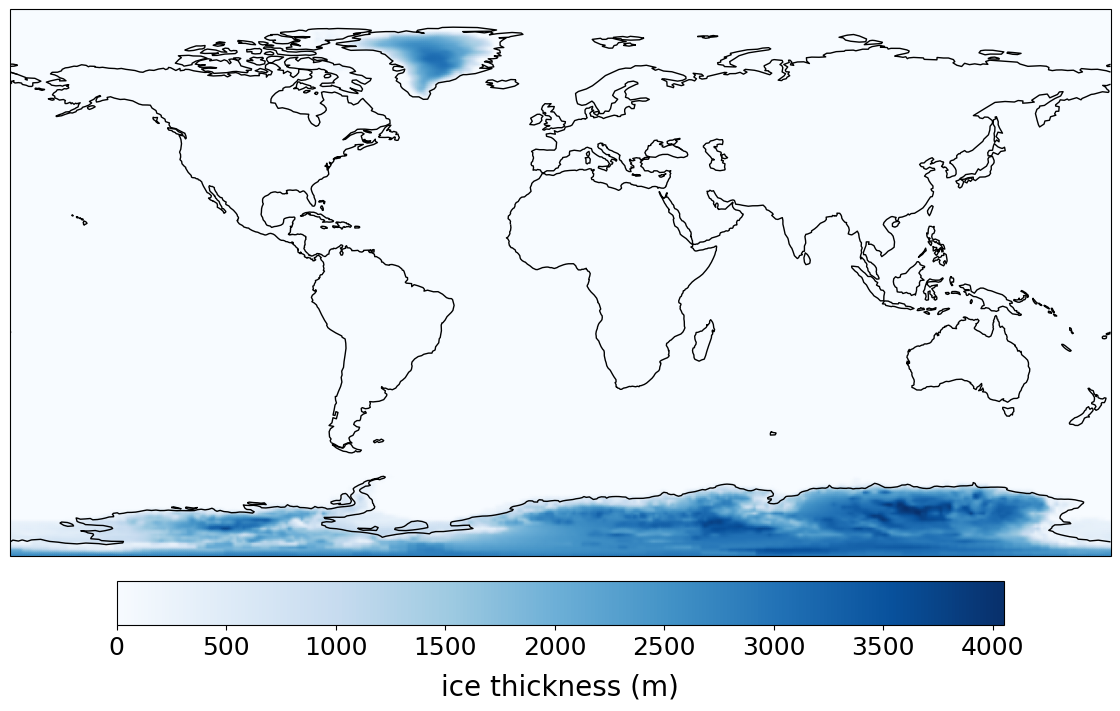

In [3]:
# set the truncation degree to work with 
L=256

# read in the sea level and ice thickness
sl,ice = SL.get_sl_ice_data(L)


# plot the data
SL.plot(sl,label = 'sea level (m)')
SL.plot(ice,label = 'ice thickness (m)',clim_pos = True)

To understand what is shown above we need to define a number of terms. First, by the **solid Earth** we will mean what remains if we imagine removing all surface water, ice sheets and glaciers, along with the atmosphere. The surface of the 
solid Earth will be called the **solid surface**.  Above each point on the solid surface there may be an ocean of height $S$ and/or an ice sheet of height $I$. Within the context of post-glacial sea level it is sufficient to regard the oceans as being in a state of **hydrostatic equilibrium**, this implying that the **ocean surface** lies on an **equipotential of gravity**. We identify the ocean surface with this equipotential even where  there is no ocean.  Given these definitions, we can now state that the **sea level**, $SL$, is the distance, measured along the local vertical, between the solid surface and the ocean surface.  The situation is summarised graphically as follows: 

![ figures/sea_level.png](figures/sea_level.png "Title")

Note that because ocean surface is defined globally, it is possible to define sea level both within the oceans, where it is positive, and on land, where it is negative.   A crucial point to remember about sea level is that it is the **relative distance** between the solid and ocean surfaces. It can, therefore, be changed by processes that modify one or both of these surfaces.



In the reality, the ocean surface undergoes short-timescale variations due to winds and tides, and also has long-term topography associated with  ocean currents. Short-timescale variations can have quite large amplitudes (e.g. around 10 metres for tides in some locations), but in discussing sea level change it is  **mean sea level** that is of interest (and what we have historical records for). The topography of the ocean surface caused by ocean currents is typically only a few centimetres in amplitude, and so negligible relative to deglacial changes of order of metres or more. For studies of modern day sea level change, however, variations in ocean currents are significant, as are **steric effects**, this meaning the expansion or contraction of the water column due to variations in  salinity and/or temperature.


  






# The ocean function


As we have seen, the definition of sea level is such that is is positive where water is present and negative otherwise. It follows that the sea level, $SL$, is not the same as the **ocean thickness**, $S$. To relate the two quantities it is useful to define the **ocean function** as follows
\begin{equation}
C(\mathbf{x}) = \left\{
\begin{array}{cc}
1 & SL(\mathbf{x}) > 0 \\
0 & SL(\mathbf{x}) \le 0
\end{array}
\right.,
\end{equation}
which allows us to write
\begin{equation}
S = C\,SL.
\end{equation}

In fact, this initial definition requires a slight modification to deal with ice shelves. At such a location there is both ice and water present, with the ice floating on top of the water. Using Archimedes principle (i.e. an isostatic balance), for such an ice shelf the following must hold
\begin{equation}
\rho_{w}\, SL  = \rho_{w} \, S + \rho_{i} \,I, 
\end{equation}
where $\rho_{w}$ is the water density and $\rho_{i}$ the ice density. From this relation, we see that the ocean thickness under an ice sheet is given by
\begin{equation}
S = SL - \frac{\rho_{i}}{\rho_{w}}I.
\end{equation}
Because the ocean thickness is non-negative by definition, it follows that
\begin{equation}
\rho_{w}SL - \rho_{i} I \ge 0,
\end{equation}
within an ice shelf. If this condition is violated, then the ice must be **grounded**. This argument neglects flow within the ice, but it is good enough for our purposes. 

Note that the inequality $\rho_{w}SL - \rho_{i} I \ge 0$ actually serves to define where water is present in the more general situation. At locations where $I = 0$, it reduces to our prior condition, while  when $I > 0$ it tells us if there is an ice shelf or a grounded ice sheet. This suggests that we can generalise the definition of the ocean function to
\begin{equation}
C(\mathbf{x}) = \left\{
\begin{array}{cc}
1 & \rho_{w}SL(\mathbf{x})-\rho_{i}I(\mathbf{x}) > 0 \\
0 & \rho_{w}SL(\mathbf{x})-\rho_{i}I(\mathbf{x}) \le 0
\end{array}
\right.,
\end{equation}
and then express the ocean thickness as
\begin{equation}
S = C\left(SL - \frac{\rho_{i}}{\rho_{w}}I\right).
\end{equation}

The following function:

```python
def ocean_function(sl0,ice0):
    C = sl0.copy()
    for ilat in range(C.nlat):
        for ilon in range(C.nlon):            
            sll  = sl0.data[ilat,ilon] 
            icel = ice0.data[ilat,ilon]            
            if(rhow*sll - rhoi*icel >= 0.): 
                C.data[ilat,ilon] = 1.
            else:
                C.data[ilat,ilon] = 0.
    return C
```


from SLmod.py can be used to determine the ocean function, with the results shown below.

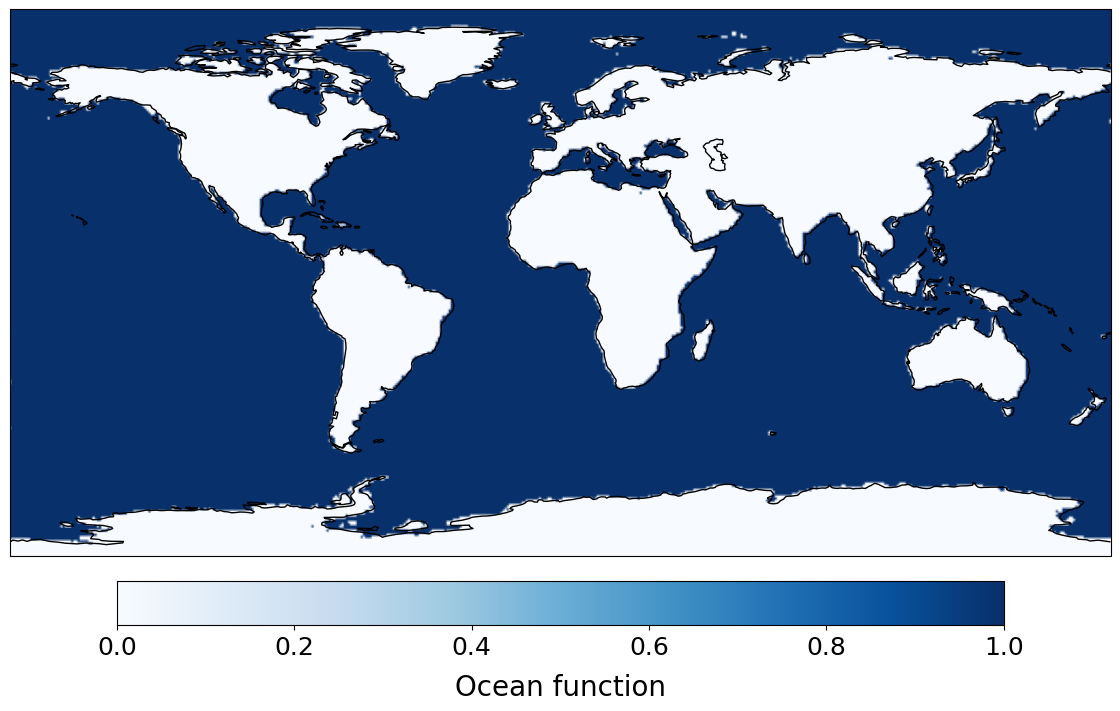

In [5]:
C = SL.ocean_function(sl,ice)
SL.plot(C,label="Ocean function",clim_pos = True)

# A simple approach to melting the Greenland ice sheet

The eventual aim of this practical is to determine the sea level change associated with melting the entire Greenland ice sheet. As a starting point, we can take a very simple approach. We first determine the (signed) mass, $\Delta M_{\mathrm{ice}}$, of the melted ice, calculate the equivalent volume of water, and distribute it uniformly across the oceans. In this manner we find that the predicted sea level change is equal to the constant
\begin{equation}
\Delta SL = -\frac{\Delta M_{\mathrm{ice}}}{\rho_{w}A}, 
\end{equation}
where $A$ is the surface area of the oceans.  Recallng the definition of the ocean function we can write:
\begin{equation}
    A = \int_{\partial M} C \, \mathrm{d} S, \quad \Delta M_{\mathrm{ice}} = \int_{\partial M} \rho_{i} (1-C) \Delta I \, \mathrm{d} S, 
\end{equation}
where the integrals are taken over the Earth's spherical reference surface $\partial M$. Note that in computing the ice mass the factor $(1-C)$ means that we neglect ice shelves. 

To compute the ocean area, $A$, practically we first note that the necessary integral can be written
\begin{equation}
A = b^{2}\int_{\mathbb{S}^{2}} C \,\mathrm{d} S, 
\end{equation}
where $b$ is the Earth's mean radius of $6371\,\mbox{km}$. Next, we use the fact that $Y_{00} = 1/\sqrt{4\pi}$ to obtain
\begin{equation}
A = \sqrt{4\pi} b^{2} C_{00}, 
\end{equation}
with $C_{00}$ the $l =0$ and $m =0$ spherical harmonic expansion coefficient of the ocean function. This calculation is implemented in the following code:
```python
def surface_integral(fun):
    fun_lm = fun.expand(lmax_calc = 0,normalization = 'ortho')
    int = np.sqrt(4*pi)*b*b*fun_lm.coeffs[0,0,0]
    return int
```
which is applied below to show that the oceans do indeed account for about 70% of the Earth's surface.
Note that in the above code, when we expand the spatial field we include the optional arguememt lmax_calc
and set its value equal to 0. This means that we do not waste time computing higher-degree coefficients that are not required.

In [6]:
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)

fraction of surface which is ocean =  0.7118907012236343


With these codes to hand, we can readily estimate the sea level change associated with melting Greenland. The first thing is to set the change, $\Delta I$ in the ice thickness:

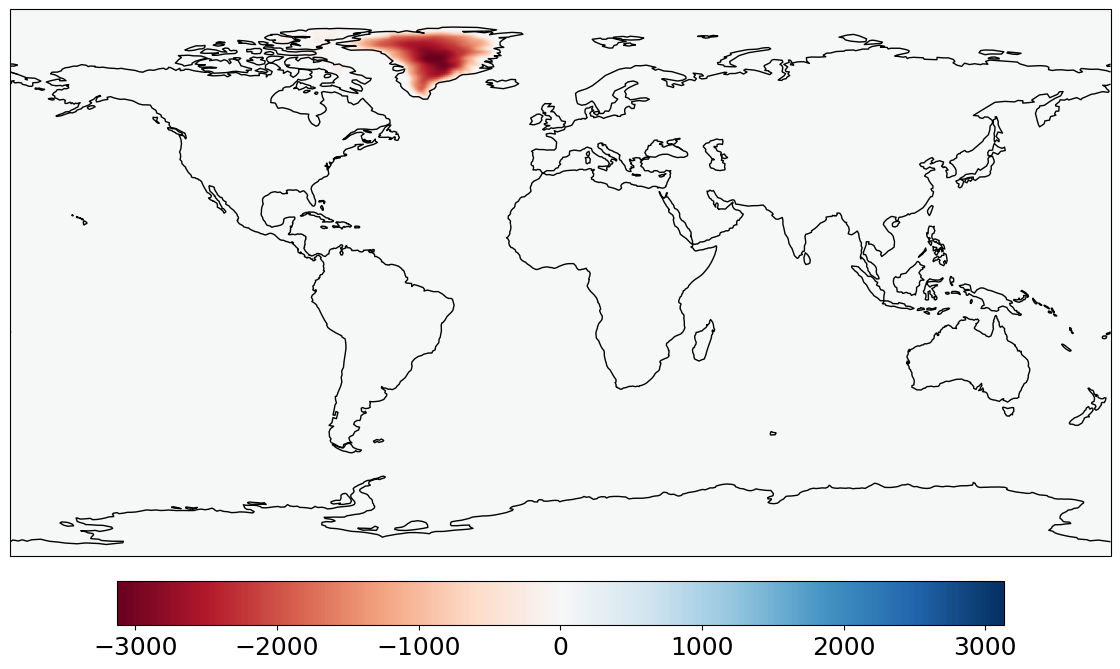

In [7]:
# initialise the change in the ice thickness
Dice = ice.copy()


for ilat,lat in enumerate(ice.lats()):
    if(lat > 0):
        Dice.data[ilat,:] *= -1.
    else:
        Dice.data[ilat,:] = 0.

# plot the result to check
SL.plot(Dice)

Finally, we can use the above formula for the sea level change along with the integration function
to obtain the desired result:

In [8]:
def uniform_sea_level(zeta):
    return -SL.surface_integral(zeta)/(rhow*A)
    
# set the direct loading term
zeta = rhoi*(1-C)*Dice

# perform the necessary integral to obtain the uniform sea level change
sl_uniform = uniform_sea_level(zeta)
print('estimated sea level change = ',sl_uniform,'m')

estimated sea level change =  7.674342080827347 m


# Modelling sea level change

The simple discussion of sea level change above neglects several key physical processes. 

- Ice sheets apply a load to the solid Earth, and also contribute to the Earth's gravitational field. Thus, any changes to ice sheet thickness will cause deformation along with associated gravitational perturbations.

- In the same way, the oceans apply a load to the solid Earth, and contribute to the gravitational field. We cannot, therefore, add new water to the oceans without there being a corresponding response
of the solid Earth.

- The ocean surface lies on an equipotential of gravity, but this potential changes as the Earth deforms. This means that we cannot determine *a prori* the ocean load, but must solve for it as part of the problem.

There are other more sublte effects in modelling sea level change including **shoreline migration** and **rotational feedbacks** that there is not time to consider. 

To understand these ideas quantitatively, let's start by considering the Earth in a state of equilibrium prior to any changes in the ice sheets. At a point $\mathbf{x}$ on the solid surface the sea level, $SL$, is defined implicitly through the requirement
\begin{equation}
\varphi(\mathbf{x} + SL \,\hat{\mathbf{r}}) = \Phi_{G}, 
\end{equation}
where $\varphi$ is the Earth's gravitational potential, $\hat{\mathbf{r}}$ a radial unit vector that defines the local vertical direction, and $\Phi_{G}$ is the *value* of the gravitational potential at the ocean surface. 

Suppose that the Earth is now disturbed by a change  $\Delta I$ to the ice height. Points on the solid surface will  be displaced in response to the combined ice and ocean loads, while the gravitational field will be correspondingly perturbed. Let $\Delta u$ denote the radial component of the surface displacement and $\Delta \varphi$ the gravitational potential perturbation. To first-order accuracy, the implicit definition of sea level
given above can be expanded to yield
\begin{equation}
\Delta SL = - \frac{1}{g}(g \Delta u + \Delta \varphi) +  \frac{\Delta \Phi_{G}}{g}, 
\end{equation}
where $g$ is the acceleration due to gravity prior to the deformation, and $\Delta \Phi_{G}$ denotes the change in the value of the gravitational potential between the new and old equipotential surfaces.  This expression links the deformation of the solid Earth to the associated sea level change. As things stand, however, it is not  useful because it contains the spatially constant term $ \frac{\Delta \Phi_{G}}{g}$ that has not been determined.

The deformation of the solid Earth results from the application of the surface load
\begin{equation}
 \Delta \sigma = \rho_{w} C \Delta SL + \rho_{i} (1-C) \Delta I. 
\end{equation}
Here the first term is that due to changes in ocean height, while the second  is that due to  changes in ice height. If we integrate
the total load over the Earth's surface we obtain
\begin{equation}
    \int_{\partial M} \Delta \sigma \,\mathrm{d} S =  \int_{\partial M} \rho_{w} C \Delta SL \,\mathrm{d} S
    +  \int_{\partial M} \rho_{i} (1-C) \Delta I \,\mathrm{d} S = 0,
\end{equation}
which vanishes because **the mass of water added to the oceans must balance that taken from the ice sheets**. Substituting the above expression for $\Delta SL$ above into this condition we obtain
\begin{equation}
\frac{\Delta \Phi_{G}}{g} = \frac{1}{g A} \int_{\partial M} C \, (g \Delta u + \Delta \varphi) \, \mathrm{d} S
- \frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \Delta I \,\mathrm{d} S. 
\end{equation}
In this manner we have arrived at the following key expression for the change in sea level:
\begin{equation}
\Delta SL = - \frac{1}{g}(g \Delta u + \Delta \phi) + \frac{1}{g A} \int_{\partial M} C \, (g \Delta u + \Delta \varphi) \, \mathrm{d} S
- \frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \Delta I \,\mathrm{d} S. 
\end{equation}
Here we note that the final term is precisely equal to the constant sea level change we estimated previously.



If we knew both the change in ice height $\Delta I$ along with the response $(\Delta U,\Delta \varphi)$ of the solid Earth we could use this formula to determined the resulting sea level change. The problem is that the response of the solid Earth is determined by the load applied to the solid Earth, and part of this load comes from the sea level change we are trying to determine! 



# Loading Love numbers

To resolve this issue we first  consider how the response of the solid Earth to an applied load can be calculated. A surface load, $\sigma$ acting on the solid Earth has two effects. First it applies a force per unit area (or a **traction**)
\begin{equation}
\mathbf{t} = - \sigma g \hat{\mathbf{r}}, 
\end{equation}
to the solid surface. Note that the sign convention is such that a positive load presses down on the surface. Next, the load has an associated mass, and the corresponding gravitational field applies a force per unit volume (or a **body force**) to the solid Earth. During the resulting deformation the shape and mass distribution in the solid Earth will change, and so its gravitational field will be perturbed. The solid Earth feels its own gravitational field, and hence there is an additional body force in the problem associated with **self-gravitation**.


Even with the simplifying assumption of spherical symmetry, numerical calculation of the resulting deformation is quite complicated. Happily the results can be expressed in a simple and useful manner using **loading Love numbers**. Let us first decompose the applied load using spherical harmonics
\begin{equation}
\Delta \sigma = \sum_{lm} \Delta \sigma_{lm}\, Y_{lm}.
\end{equation}
The radial displacment, $\Delta u$, and gravitational potential perturbation, $\Delta \varphi$, caused by this load can be similarly
expanded as
\begin{equation}
   \Delta u = \sum_{lm} \Delta u_{lm}\, Y_{lm},\quad \Delta \varphi = \sum_{lm} \Delta\varphi_{lm}\, Y_{lm}.
\end{equation}
Because we are dealing with a linearised theory, the deformation due to this load is a sum of the responses associated with the individual terms in the summation.  Moreover, because the solid Earth is assumed to be spherically symmetric it can be shown that the load $\Delta \sigma_{lm} \,Y_{lm}$ produces a response only at the **same degree and order**, such that
\begin{equation}
\Delta u_{lm} = h_{l}\,\Delta \sigma_{lm}, \quad \Delta \varphi_{lm} =  \,k_{l}\,\Delta \sigma_{lm}, 
\end{equation}
where $h_{l}$ and $k_{l}$ are the two **loading Love numbers**. It is worth noting that the Love numbers depend  on spherical harmonic degree but not order.


Calculation of loading Love numbers requires solution of the partial differential equations governing elastic deformation of a self-gravitating planet, and this is quite complicated. The code below simply loads in  pre-computed loading Love numbers calculated for the Earth model PREM of Dziewonski and Anderson (1981). Note that we only show the results for $l \ge 1$. Degree one Love numbers are not needed within this problem as all loads average to zero due to conservation of mass.


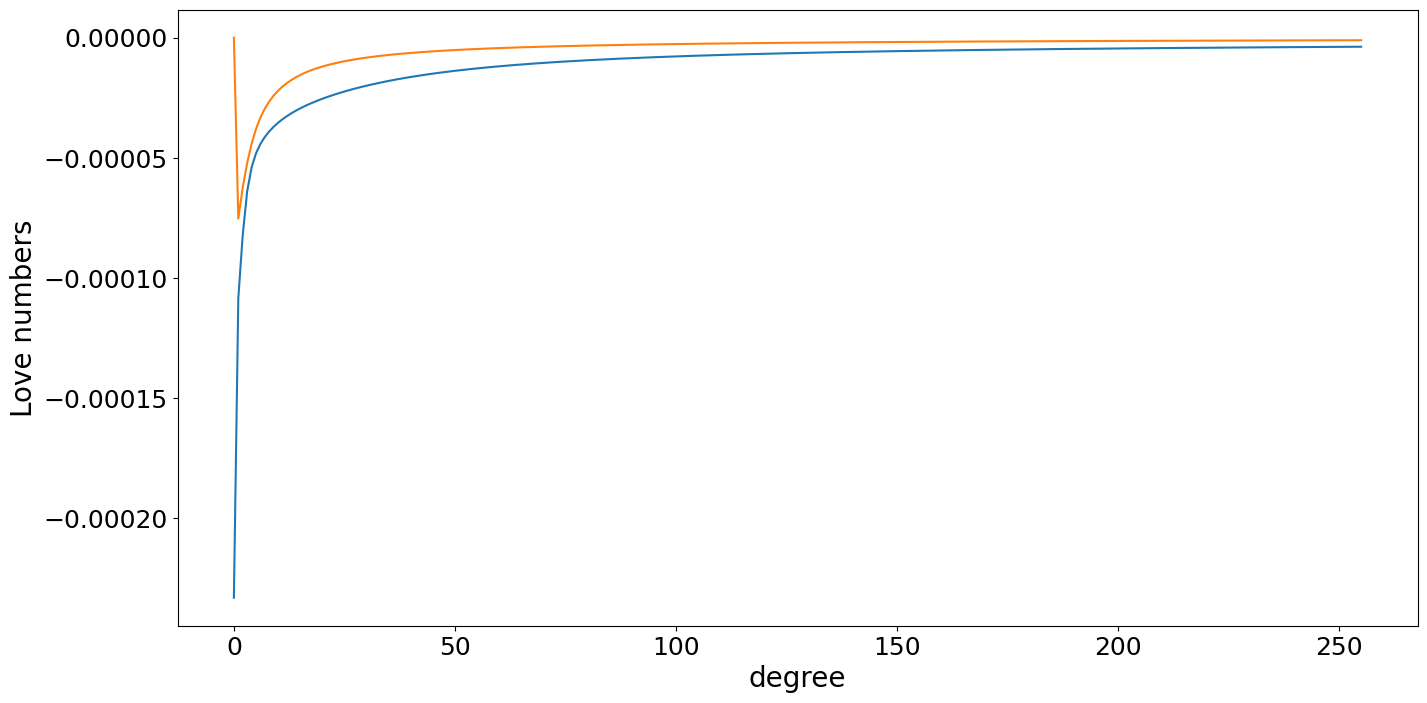

In [9]:
# the skipped outputs are tidal love numbers that 
# we will not discuss. 
h,k,_,_ = SL.love_numbers(L)

# plot the love numbers as a function of degee
# note that we plot k/g as it has the same dimensions
# as h (length per unit load)
plt.figure()
plt.plot(h[1:])
plt.plot(k[1:]/g)
plt.xlabel('degree')
plt.ylabel('Love numbers')
plt.show()

A key qualitative point is that the amplitude of both the Love numbers decreases rapidly as $l$ increases. This means that the response to a unit load having a long wavelength is larger than that to a unit load with a smaller wavelength. This is the main reason that loading matters for sea level change when an ice sheet melts but is irrelevant if you jump into the ocean. 

# The sea level equation

Let us recall the main equations governing sea level change. First we have 
\begin{equation}
 \Delta \sigma = \rho_{w} C \Delta SL + \rho_{i} (1-C) \Delta I. 
\end{equation}
which expresses the applied surface load in terms of changes to the sea level and ice thickness. As we have noted, it is only the latter that is specified *a priori* in the problem. Next we have 
\begin{equation}
\Delta SL = - \frac{1}{g}(g \Delta u + \Delta \phi) + \frac{1}{g A} \int_{\partial M} C \, (g \Delta u + \Delta \varphi) \, \mathrm{d} S
- \frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \Delta I \,\mathrm{d} S. 
\end{equation}
which shows how the change in sea level can be computed from the change in ice thickness along with the deformation fields $(\Delta u,\Delta \varphi)$ resulting from the **total** surface load.

If we somehow knew $\Delta SL$, we could calculate $\Delta \sigma$, apply Love numbers to find $(\Delta u,\Delta \varphi)$, and then use the second formula to recompute $\Delta SL$. This is obviously a circular process, but it does suggest an **iterative approach** to the problem:

- Form an initial guess for the sea level change. In practice this might be the uniform sea level change
\begin{equation}
 -\frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \Delta I \,\mathrm{d} S,
\end{equation}
we determined earlier. 

- From the assumed sea level change, calculate the total surface load $\Delta \sigma$, and then use Love numbers to obtain the associated deformation $(\Delta u,\Delta \varphi)$.

- Substitute the computed deformation fields into the expression for sea level to obtained a new estimate
for $\Delta SL$.

- Repeat the whole process, hoping that convergence will be obtained.

Within the remainder of this practical we will implement this idea and see that it really does work. But it is worth thinking through the problem a little more to understand what is happening. First we note that all the equations in the theory of linear. The relationship between the change in sea level $\Delta SL$ and the load $\Delta \sigma$, therefore, takes the form 
\begin{equation}
    \Delta SL = K \,\Delta \sigma, 
\end{equation}
where $K$ is a certain **linear operator** that maps one function linearly into another. The detailed form of $K$ could be determined in terms of spherical harmonics and Love numbers, but this is not necessary. We will, however, note that  concretely this operator can be written
\begin{equation}
(K \,\Delta \sigma) (\theta,\phi) = \int_{\partial M} k(\theta,\phi,\theta',\phi') \, \Delta \sigma(\theta',\phi') \,
\mathrm{d} S', 
\end{equation}
where $k$ is a certain function. Such a linear operator $K$ is said to be an **integral operator** for obvious reasons, while $k$ is known as its **kernel**.

If we substitute the form of the load in the sea level problem into the above equation we find
\begin{equation}
\Delta SL =  K\,[\rho_{i} (1-C)\Delta I] +  K\, [\rho_{w}C\,\Delta SL], 
\end{equation}
where, crucially, we see that $\Delta SL$ occurs on both sides! Thus we arrived at the **sea level equation**, this being an example of a linear **integral equation**. The first term on the right hand side of this equation can be computed directly from the change in ice thickness, and so we set
\begin{equation}
\Delta \tilde{SL} =  K\,[\rho_{i} (1-C)\Delta I].
\end{equation}
To futher simplify notations we also define a new integral operator $\tilde{K}$ by
\begin{equation}
\tilde{K}\,  \Delta SL =  K\,  [\rho_{w}C\,\Delta SL], 
\end{equation}
so that the sea level equation can be written more concisely as
\begin{equation}
\Delta SL = \Delta \tilde{SL}  + \tilde{K} \,\Delta SL.
\end{equation}


One way to solve the sea level equation is to bring $\Delta SL$ entirely over the left hand side as
\begin{equation}
(1-\tilde{K}) \Delta SL = \Delta \tilde{SL}, 
\end{equation}
where $1$ on the left hand side is the identity operator that maps a function to itself. The solution of this equation is then given by
\begin{equation}
\Delta SL = (1-\tilde{K})^{-1} \Delta \tilde{SL}. 
\end{equation}
The necessary inverse operator can then be evaluated  through a so-called **Neumann series**
\begin{equation}
    (1-\tilde{K})^{-1} = \sum_{n=0}^{\infty} \tilde{K}^{n} = 1 + \tilde{K} + \tilde{K}^{2} + \tilde{K}^{3} + \cdots, 
\end{equation}
which can be seen as a generalisation of a binomial expansion to linear operators. Convergence of such an expansion is not assured, but it can be shown to hold so long as $\tilde{K}$ is small in an appropriate sense. 

The iterative scheme for solving the sea level equation takes the form
\begin{equation}
\Delta SL_{i+1} = \Delta \tilde{SL} + \tilde{K} \Delta SL_{i}, 
\end{equation}
for $i = 0,1,2,\dots$, with $\Delta SL_{0}$ being some initial guess. For the first iteration we have
\begin{equation}
\Delta SL_{1} = \Delta \tilde{SL} + \tilde{K} \Delta SL_{0}.
\end{equation}
Next we find
\begin{align}
\Delta SL_{2} &= \Delta \tilde{SL} + \tilde{K} \Delta SL_{1}, \\
              &=  \Delta \tilde{SL}  + \tilde{K} [ \Delta \tilde{SL} + \tilde{K} \Delta SL_{0}], \\
              &=  \Delta \tilde{SL}  + \tilde{K} \Delta \tilde{SL} + \tilde{K}^{2} \Delta SL_{0}, 
\end{align}
while the third is similarly found to be
\begin{align}
\Delta SL_{3} &=  \Delta \tilde{SL}  + \tilde{K} \Delta \tilde{SL} + \tilde{K}^{2} \Delta \tilde{SL}
+ \tilde{K}^{3} \Delta SL_{0}.
\end{align}
Noting the pattern, the $p$th term is given by
\begin{align}
\Delta SL_{p} &=  \sum_{n=0}^{p-1} \tilde{K}^{n}\Delta \tilde{SL}  
+ \tilde{K}^{p} \Delta SL_{0}, 
\end{align}
and so letting $p$ increase the result tends to the Neumann series so long as the condition 
\begin{equation}
\lim_{n\rightarrow \infty}\tilde{K}^{n} (\Delta SL_{0}) = 0,
\end{equation}
holds for any $\Delta SL_{0}$. It can be shown that this is prescisely the requirement for the 
Neumann series to converge, and hence the iterative method for solving the sea level equation has a solid theoretical foundation.




# Numerical implementation

We now consider how the iterative solution to the sea level equation can be implemented numerically. The first step is to form our initial guess at the sea level. Here we can use the uniform value calculated earlier

In [10]:
# create a suitable grid for the sea level change by copying the 
# initial sea level values
Dsl = sl.copy()

# set the data equal to the constant calculated earlier
Dsl.data[:,:] = sl_uniform

Given this initial guess at the sea level, we can readily form the associated surface load, $\sigma$, and then use the Love numbers to compute the solid Earth response. This is done in the code below which is written as a function because we will have need to use this again.

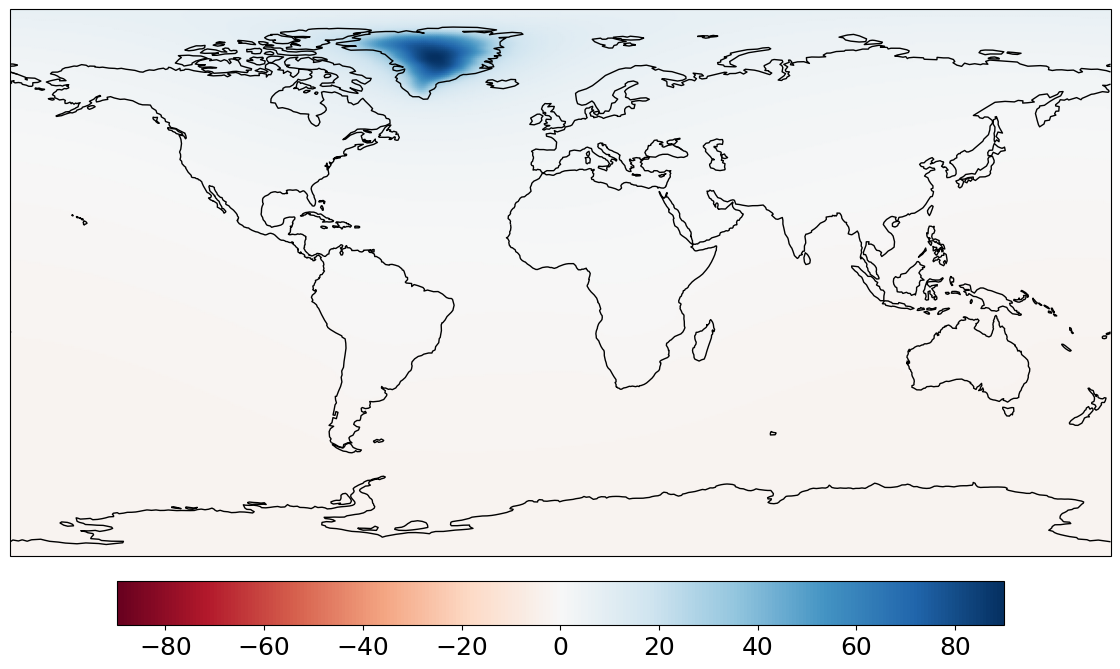

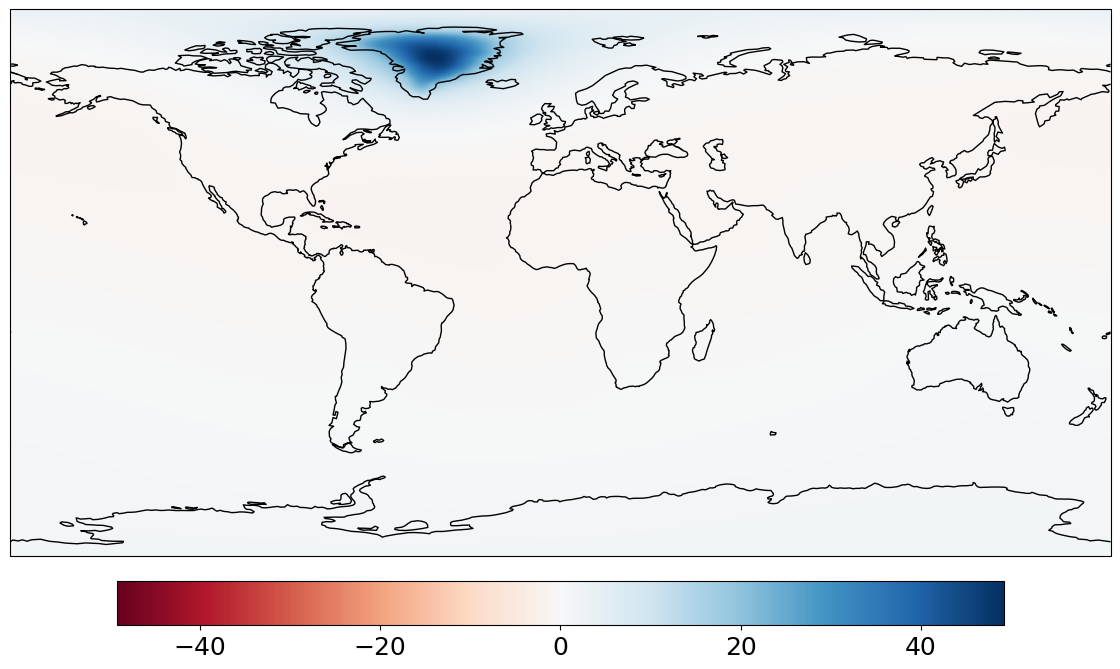

In [11]:
def solid_earth_response(sigma):
   
    # transform to the spherical harmonic domain
    sigma_lm = sigma.expand(normalization = 'ortho')

    # initialise storage for the coefficients of u and phi
    u_lm   = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
    phi_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')

    # perform the l-dependent scaling with the Love numbers
    for l in range(L+1):
        u_lm.coeffs[:,l,:]   = h[l]*sigma_lm.coeffs[:,l,:]
        phi_lm.coeffs[:,l,:] = k[l]*sigma_lm.coeffs[:,l,:]
    
    # transform to spatial fields (note we work with Gauss Legendre grids)
    u   = u_lm.expand(grid = 'GLQ')
    phi = phi_lm.expand(grid='GLQ')
    
    return u,phi

# set the surface load (recall zeta = rhoi*(1-C)*Dice)
sigma = rhow*C*Dsl + zeta

# get the response
u,phi = solid_earth_response(sigma)

# plot the fields (scaling the potential to make it a length)
SL.plot(u)
SL.plot(phi/g)

We are now in a position to update the value of the sea level using
\begin{equation}
\Delta SL = - \frac{1}{g}(g \Delta u + \Delta \phi) + \frac{1}{g A} \int_{\partial M} C \, (g \Delta u + \Delta \varphi) \, \mathrm{d} S
- \frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \Delta I \,\mathrm{d} S. 
\end{equation}
Again, we write a function to do this so that it can be reused.

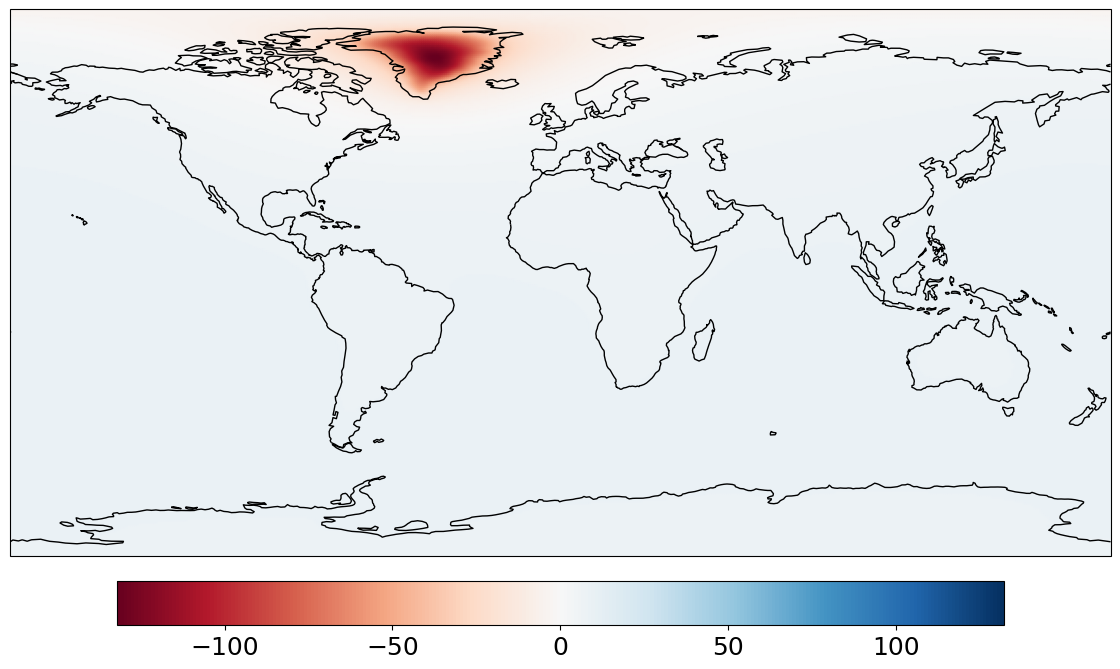

In [12]:
def sea_level_from_deformation(C,sl_uniform,u,phi):
    
    # set the spatially varying part of the sea level
    Dsl = -(1/g)*(g*u + phi)
    
    # compute the first integral term
    I1 = SL.surface_integral(C*Dsl)
    
    # add in constant terms to sea level
    Dsl.data[:,:] += -I1/A + sl_uniform
    
    return Dsl

# get the updated sea level and plot it
Dsl = sea_level_from_deformation(C,sl_uniform,u,phi)
SL.plot(Dsl)  

With the above two functions at hand, we're in a position to carry out the iteration and this is the aim of the practical. 

# What you need to know and be able to do

- Explain what is meant by sea level along with associated definitions such as the ocean and solid surfaces.

- Derive the formula used to estimate globally uniform sea level change.

- Explain how loading Love numbers can be used to compute the deformation associated with a given load, and outline how this can be done numerically. Here the emphasis should be on the key steps involved, and not on the details of any of the algorithms.

- Explain qualitatively how the sea level equation is obtained. Here you do not need to reproduce any of the detailed formulae, but you might be asked to carrry out steps from the derivation given the necessary information (e.g. show how conservation of mass is used to determine the uniform term within the sea level change).
- What an integral equation is, and how it can be solved in an iterative manner. You do not need to prove why the Neumann series converges, but should be familiar with its form.
- describe why iterative methods are useful in solving the sea level equation and explain in outline the steps necessary to do this, 


# Practical

Using the functions written within the lecture, implement an iterative solution of the sea level equation. Use this to investigate sea level change associated with a different melting scenarios. 